BIBLIOTECAS


In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.lines import Line2D
import matplotlib.ticker as ticker
import openpyxl
from openpyxl import load_workbook
from openpyxl.drawing.image import Image
import io
import pandas as pd
import psycopg2
from scipy.interpolate import make_interp_spline, UnivariateSpline
import numpy as np


CONEXIÓN A BASE DE DATOS

In [2]:
def connect_to_db(host, user, password, database, port): # Conexión a la base de datos
    try:
        conexion = psycopg2.connect(
            host=host, 
            user=user,
            password=password,
            database=database,
            port=port,
       
        )
        conexion.autocommit = True # Autoconfirmación
        return conexion
    except psycopg2.Error as e:
        print(f"Error en la conexión a la base de datos: {e}")
        return None

def execute_query(conexion, query): # Ejecución
    try:
        cursor = conexion.cursor()  # Crear un cursor para ejecutar consultas
        cursor.execute(query)
        result = cursor.fetchall()  # Obtener los resultados
        columns = [desc[0] for desc in cursor.description]
        cursor.close()
        return result, columns
    except psycopg2.Error as e:
        print(f"Error en la ejecución de la consulta: {e}")
        return None, None

def close_connection(conexion): # Cierre
    if conexion:
        conexion.close()

PROCESAMIENTO Y LIMPIEZA DE DATOS

In [3]:
def process_data(result, columns): 
    df = pd.DataFrame(result, columns=columns) # Crear un DataFrame
    if not df.empty:
        df.dropna(subset=['fecha', 'hora'], inplace=True) # Eliminar filas con valores nulos
        df['Fecha_Hora'] = pd.to_datetime(df['fecha'].astype(str) + ' ' + df['hora'].astype(str), errors='coerce') # Crear una columna con la fecha y hora
        df.drop(columns=['fecha', 'hora'], inplace=True) # Eliminar las columnas originales
        df.sort_values('Fecha_Hora', inplace=True) # Ordenar por fecha y hora
    return df

def process_precipitation_data(result, columns): 
    df_precip = pd.DataFrame(result, columns=columns) # Crear un DataFrame
    if not df_precip.empty: # Si el DataFrame no está vacío
        df_precip['Fecha_Hora'] = pd.to_datetime(df_precip['fecha'].astype(str) + ' ' + df_precip['hora'].astype(str), errors='coerce') 
        df_precip.drop(columns=['fecha', 'hora'], inplace=True) 
        df_precip.sort_values('Fecha_Hora', inplace=True) 
    return df_precip

OBTENER UMBRALES

In [4]:
def umbrales(conexion, tabla, fecha_inicio, fecha_fin, schema="MV_PIEZOMETROS", table="pz_abiertos", debug=False):
    """
    Devuelve un diccionario con los valores de umbrales del instrumento (nivel_umbral_1, 2, 3).
    Filtra por id_instrumento y rango de fechas.
    """

    umbral_cols = ["nivel_umbral_1", "nivel_umbral_2", "nivel_umbral_3"]
    umbrales = {}

    for col in umbral_cols:
        query_valor = f"""
        SELECT "{col}"
        FROM "{schema}"."{table}"
        WHERE "{col}" IS NOT NULL
          AND "id_instrumento" = '{tabla}'
          AND "fecha" BETWEEN '{fecha_inicio}' AND '{fecha_fin}'
        ORDER BY "fecha" DESC
        LIMIT 1
        """
        valor_result, _ = execute_query(conexion, query_valor)

        if valor_result and valor_result[0][0] is not None:
            raw_val = valor_result[0][0]
            try:
                val = float(raw_val)  # convertir de varchar a float
            except Exception:
                val = raw_val
            umbrales[col] = val
            if debug:
                print(f"✔ {col}: {val}")
        else:
            if debug:
                print(f"⚠ No se encontró valor para {col} en {tabla} dentro del rango.")

    return umbrales if umbrales else None


GRAFICAR

In [5]:

def plot_data(df_instrumento, df_precip, tabla, conexion, excel_path, sheet_name, cell):
    
    # Crear una figura y un eje
    fig, ax1 = plt.subplots(figsize=(14, 7))
    plt.style.use('bmh')  # Estilo de Seaborn

    # Asegurarse de que la columna de 'Fecha_Hora' sea de tipo datetime
    df_instrumento['Fecha_Hora'] = pd.to_datetime(df_instrumento['Fecha_Hora'])


    # ===================================================================================================================
    # CONFIGURACIÓN DEL EJE Y1 (PRIMARIO)
    # ===================================================================================================================

    # Configurar los decimales del eje Y primario
    ax1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))

    ## Graficar los datos con línea suavizada ##
    datos_validos = df_instrumento[['Fecha_Hora', 'elevacion_piezometrica']].dropna() # Eliminar filas con valores nulos
    x = mdates.date2num(datos_validos['Fecha_Hora']) # Convertir fechas a números
    y = datos_validos['elevacion_piezometrica'].values 

    # Suavizar la línea si hay más de 3 puntos
    if len(x) > 3: 
        x_suave = np.linspace(x.min(), x.max(), 200) 
        spl = make_interp_spline(x, y, k=2) # Spline cúbica
        y_suave = spl(x_suave) 

        # Graficar línea suavizada
        serie1, = ax1.plot(mdates.num2date(x_suave), y_suave, 
                    color="#00518BE4", 
                    linewidth=2, 
                    label="Nivel Freático")

        # Graficar puntos originales
        ax1.plot(datos_validos['Fecha_Hora'], 
                 y, 'o',   
                 markersize=5.2,
                 markerfacecolor='#00008B',
                 color='#00518BE4', 
                 label='Datos originales'
                 )

        # # Etiquetar puntos
        # for fecha, valor in zip(datos_validos['Fecha_Hora'], y):
        #     ax1.annotate(f"{valor:.2f}", (fecha, valor), 
        #                  textcoords="offset points", 
        #                  xytext=(0, 8), 
        #                  ha='center', 
        #                  fontsize=8, 
        #                  color='black')
    else:
        # Si hay pocos puntos, graficar normal
        serie1, = ax1.plot(
            datos_validos['Fecha_Hora'],
            y,
            color="#00518BE4",
            label='Nivel Freático',
            linewidth=2,
            marker='o',
            markerfacecolor='#00008B',
            markersize=5.2,
            zorder=3
        )
    

    # Calcular minimo y máximo valor de fechas
    fecha_min = df_instrumento['Fecha_Hora'].min()
    fecha_max = df_instrumento['Fecha_Hora'].max()

    # Obtener umbrales para la tabla específica
    tablas_excluir_umbrales = [""]  # Reemplaza con los nombres de las tablas
    umbrales_instrumento = None  # Inicializar la variable de umbrales

    if tabla not in tablas_excluir_umbrales:  # Verificar si la tabla no está en la lista de exclusión
        umbrales_instrumento = umbrales(conexion, tabla, fecha_inicio, fecha_fin)  # Llamada a la función
        if umbrales_instrumento:
            colores_umbral = ['yellow', 'orange', 'red']
            nombres_umbral = {
                            'nivel_umbral_1': 'Nivel Umbral 1',
                            'nivel_umbral_2': 'Nivel Umbral 2',
                            'nivel_umbral_3': 'Nivel Umbral 3'                 
                            }

            for i, (nombre_umbral, valor_umbral) in enumerate(umbrales_instrumento.items()):
                if valor_umbral is not None:
                    color = colores_umbral[i] if i < len(colores_umbral) else 'black'
                    ax1.axhline(
                        y=valor_umbral,
                        color=color,
                        linestyle='--',
                        linewidth=1.5,
                        label=nombres_umbral.get(nombre_umbral, nombre_umbral)  # Usa el nombre legible
                    )

            
    #---------------------------------------------------------------------------------#
    # Ajustar los límites del eje Y primario si hay datos válidos
    if not datos_validos.empty and not umbrales_instrumento:
        y_min = datos_validos['elevacion_piezometrica'].min()
        y_max = datos_validos['elevacion_piezometrica'].max()

        if pd.notna(y_min) and pd.notna(y_max):  # verificar que no sean NaN
            ax1.set_ylim(y_min - 1, y_max + 2)

    #---------------------------------------------------------------------------------#


    # ===========================================================================================
    # CONFIGURACIÓN DEL EJE Y2 (SECUNDARIO)
    # ===========================================================================================

    # Agrupar y calcular el máximo diario
    df_precip['Fecha_Hora'] = pd.to_datetime(df_precip['Fecha_Hora'])
    df_precip.set_index('Fecha_Hora', inplace=True) # Establecer la columna 'Fecha_Hora' como índice
    df_precip_diario = df_precip.resample('D').max().reset_index() # Agrupar por día y calcular el máximo diario

    # Decidir si usar los datos originales o los datos agrupados por día
    rango_dias = (df_instrumento['Fecha_Hora'].max() - df_instrumento['Fecha_Hora'].min()).days # Calcular el rango de días
    if rango_dias == 0:
        rango_dias = 1  # Evitar división por cero

    # Número de datos de precipitación
    num_datos = len(df_precip) # Número de datos de precipitación
    if num_datos == 0:
        num_datos = 1  # Evitar división por cero      

    # Decidir si usar los datos originales o los datos agrupados por día
    if num_datos / rango_dias > 5000:  # Si la densidad de datos es alta, usar datos diarios
        df_precip_agrupado = df_precip_diario
    else:  # Si la densidad de datos es baja, usar los datos originales
        df_precip_agrupado = df_precip.reset_index()


    # Calcular el ancho de las barras en función de la densidad de los datos
    if fecha_min ==fecha_max:
        ancho_barra = 0.008 # Ancho de las barras si solo hay un punto
    elif (fecha_max - fecha_min).days <= 10:
        ancho_barra = 0.015  # Ancho de las barras si el rango es menor o igual a 10 días
    else:
        ancho_barra = max(0.038, rango_dias / num_datos * 0.15)  # Cálculo dinámico para más días
 
    # Dibujar las barras de precipitación
    if not df_precip_agrupado.empty:
        ax2 = ax1.twinx()
        ax2.bar(
            df_precip_agrupado['Fecha_Hora'], 
            df_precip_agrupado['rain_mm_tot'], 
            label='Precipitación', 
            color='#009ACD', 
            alpha=0.4,          # Transparencia de las barras
            width=ancho_barra,  # Ancho de las barras
            zorder=0            # Dibuja las barras detrás de las líneas
        )
        ax2.set_ylabel('Precipitación (mm/día)', color='black', fontsize=14)
        ax2.tick_params(axis='y', labelcolor='black', labelsize=12)
        ax2.grid(False)  # Desactivar la cuadrícula del eje Y secundario
        ax2.set_ylim(0, df_precip['rain_mm_tot'].max() + 5) # Ajustar el límite superior del eje Y secundario

        # Configurar los decimales del eje Y secundario
        ax2.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.0f'))


    # =============================================================================================
    # CONFIGURACIÓN DEL EJE X
    # =============================================================================================

    # Si solo hay un punto, ajusta los límites del eje X para que se centren en ese punto
    if fecha_min == fecha_max:
        fecha_min -= pd.Timedelta(days=1)  # Un día antes
        fecha_max += pd.Timedelta(days=1)  # Un día después
    
    # Definir los límites de fechas en el eje X
    ax1.set_xlim([fecha_min, fecha_max])

    # Calcular el rango de días
    rango_dias = (fecha_max - fecha_min).days
    if rango_dias == 0: # Evitar división por cero
        rango_dias = 1  # Asignar un valor mínimo para evitar errores

    # Ajuste dinámico del intervalo en el eje X
    if rango_dias > 365:
        intervalo = 60  # Cada 2 meses aprox.
    elif rango_dias > 180:
        intervalo = 30  # Cada 1 mes
    elif rango_dias > 90:
        intervalo = 15  # Cada 15 días
    elif rango_dias > 31:
        intervalo = 7  # Cada semana
    elif rango_dias <= 31:
        intervalo = 1  # Cada día
    else:
        intervalo = max(1, rango_dias// 10)  # Dividir en 10 intervalos como máximo

    ax1.xaxis.set_major_locator(mdates.DayLocator(interval=intervalo))  # Intervalo de días
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
    ax1.tick_params(axis='x', labelsize=10, rotation=90)

    # Validar las etiquetas del eje X
    ticks = ax1.get_xticks()
    new_labels = [mdates.num2date(num).strftime('%d-%m-%Y') for num in ticks]
    if len(new_labels) > 0:
        new_labels[-1] = fecha_max.strftime('%d-%m-%Y')  # Cambiar la última etiqueta a la última fecha
    
    # Asegurar que la última fecha esté en las etiquetas del eje X
    # fechas_ticks = list(ax1.get_xticks())  # Obtener los ticks actuales
    # fechas_ticks.append(mdates.date2num(fecha_max))  # Agregar la última fecha como tick
    # ax1.set_xticks(fechas_ticks)  # Actualizar los ticks del eje Xz
   

    # ===============================================================================
    # AJUSTES GENERALES DEL GRÁFICO
    # ===============================================================================

    # Cambiar los guiones bajos (_) por guiones (-) en el nombre de la tabla para el título
    titulo_tabla = tabla.replace('_', '-') # Cambiar los guiones bajos (_) por guiones (-) en el nombre de la tabla para el título
    
    ax1.set_title(f'Nivel Freático {titulo_tabla}', fontsize=18, fontweight='bold') # Título del gráfico
    ax1.set_ylabel('Elevación (msnm)', fontsize=14) # Etiqueta del eje Y primario
    ax1.tick_params(axis='y', labelcolor='black', labelsize=12) # Configuración del eje Y primario
    ax1.tick_params(axis='x', labelsize=12) # Configuración del eje X
    ax1.grid(True, linestyle='--', color='gray', alpha=0.7) # Cuadrícula del gráfico

    # Eliminar el borde superior del gráfico
    ax1.spines['top'].set_visible(False)
    if not df_precip.empty:
        ax2.spines['top'].set_visible(False)

    # Eliminar el fondo gris del gráfico
    ax1.set_facecolor('white')

    # Cambiar el color del borde del gráfico
    for spine in ax1.spines.values():
        spine.set_edgecolor('silver')
        spine.set_linewidth(0.01)



    # ================================================================================================
    #       LEYENDA
    # ==================================================================================================

    # Combinar leyendas de ambos ejes
    lines = [serie1]
    labels = [serie1.get_label()]
    if not df_precip.empty:
        lines.append(Line2D([], [], color='#009ACD', linewidth=4, linestyle='-'))
        labels.append('Precipitación')

    # Agregar líneas de umbral si corresponde

    if umbrales_instrumento:
        colores_umbral = ['yellow', 'orange', 'red']
        for i, (nombre_umbral, valor_umbral) in enumerate(umbrales_instrumento.items()):
            color = colores_umbral[i] if i < len(colores_umbral) else 'black'
            lines.append(Line2D([0], [0], color=color, linestyle='--', linewidth=1.5))
            labels.append(nombres_umbral.get(nombre_umbral, nombre_umbral))


    # Configuración de la leyenda
    ax1.legend(
        lines, labels, loc='lower center', bbox_to_anchor=(0.5, -0.4), ncol=5, 
        frameon=True, fontsize=12, facecolor='white', edgecolor='silver'
    )

    # Ajustar todo el diseño
    fig.tight_layout(rect=[0, 0, 1, 0.95])

    # Mostrar el gráfico
    plt.show()

    # ==========================
    # GUARDAR EN EXCEL
    # ==========================
    try:
        img_stream = io.BytesIO()
        fig.savefig(img_stream, format='png', bbox_inches='tight')
        img_stream.seek(0)
        img = Image(img_stream)

        # Ajustar el tamaño de la imagen
        img.width = 17.7 * 37.795275591
        img.height = 7 * 37.795275591

        # Insertar la imagen en el archivo Excel
        wb = load_workbook(excel_path)
        ws = wb[sheet_name]

        # Buscar y eliminar cualquier imagen existente en la misma celda
        for image in ws._images:
            if image.anchor._from.col == openpyxl.utils.cell.column_index_from_string(cell[0]) - 1 and \
               image.anchor._from.row == int(cell[1:]) - 1:
                ws._images.remove(image)
                break

        ws.add_image(img, cell)
        wb.save(excel_path)
        print(f"Gráfica insertada en {sheet_name} en la celda {cell}")
    except Exception as e:
        print(f"Error al guardar o insertar la gráfica: {e}")
    finally:
        plt.close(fig)


EJECUTAR CONSULTA Y GRAFICAR

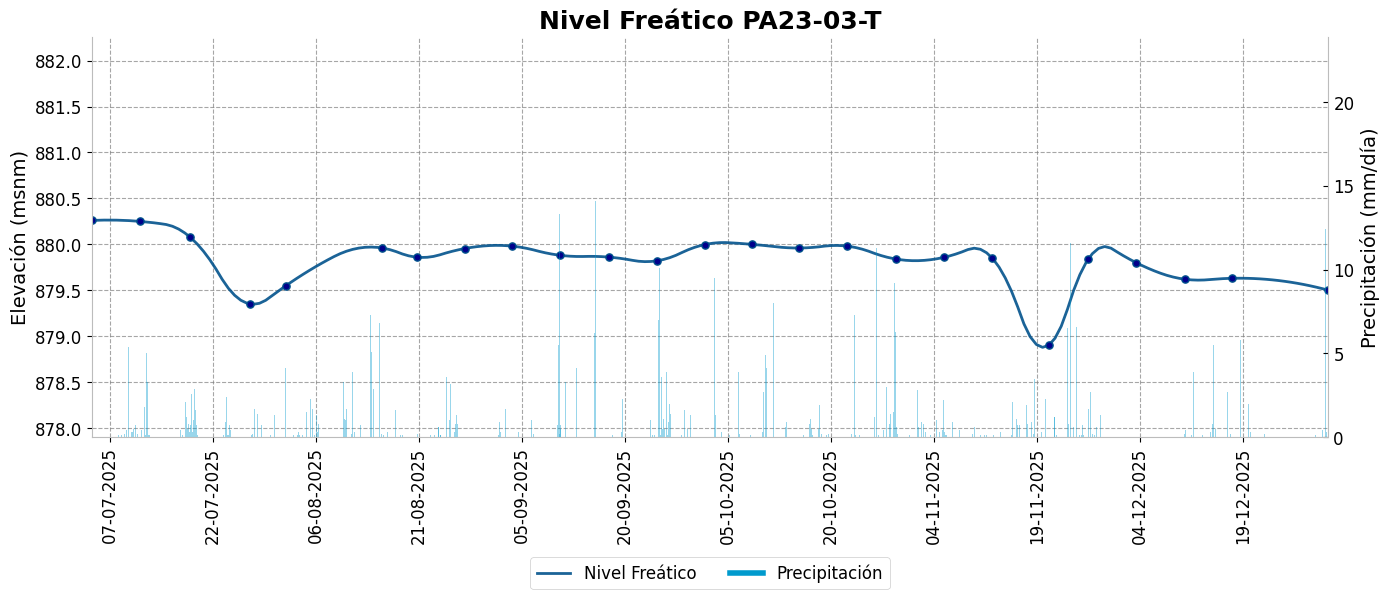

Gráfica insertada en PA23-03-T en la celda C20


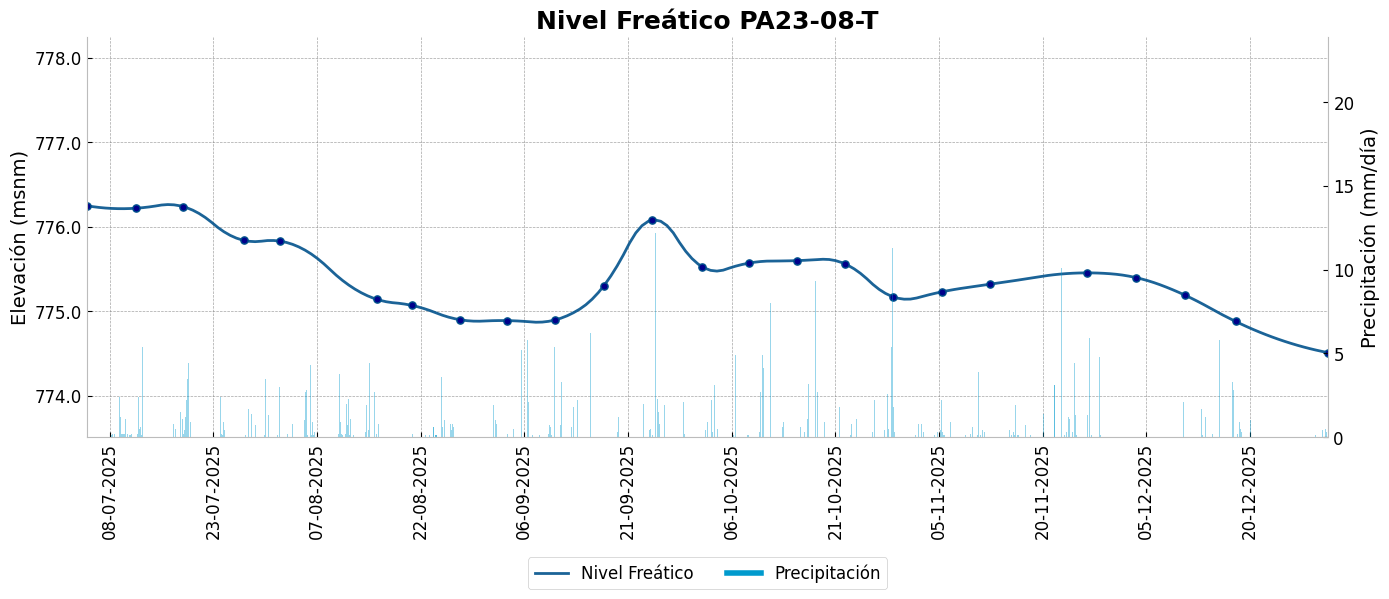

Gráfica insertada en PA23-08-T en la celda C20


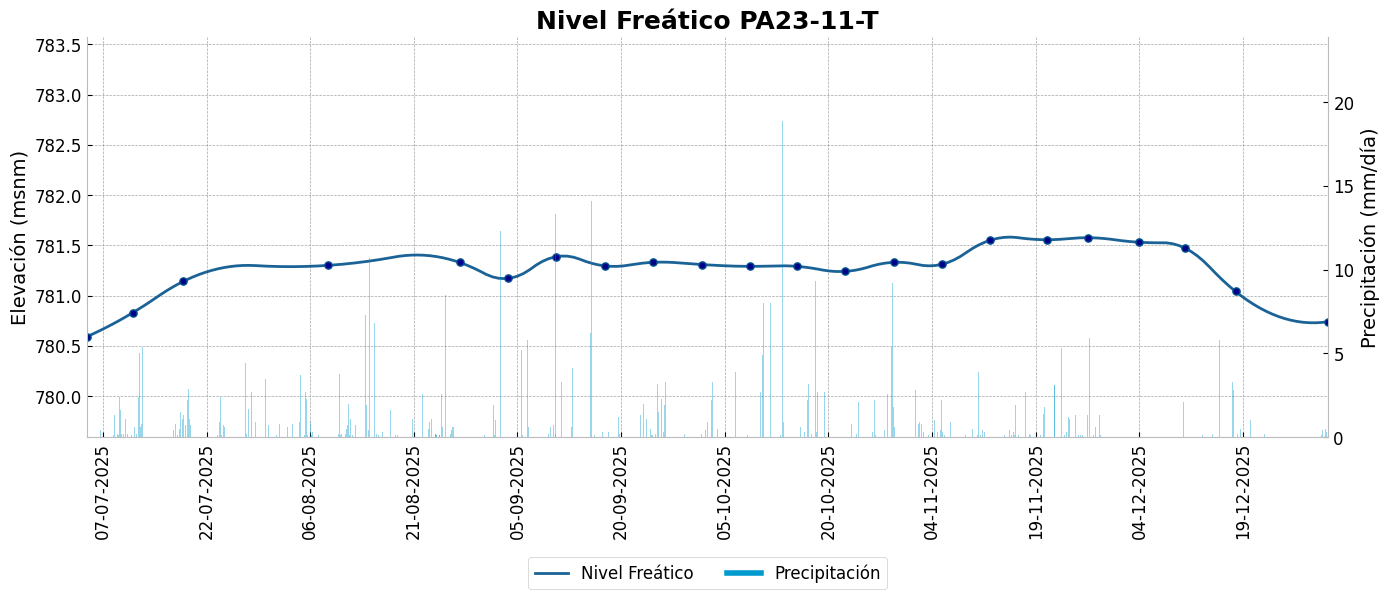

Gráfica insertada en PA23-11-T en la celda C20


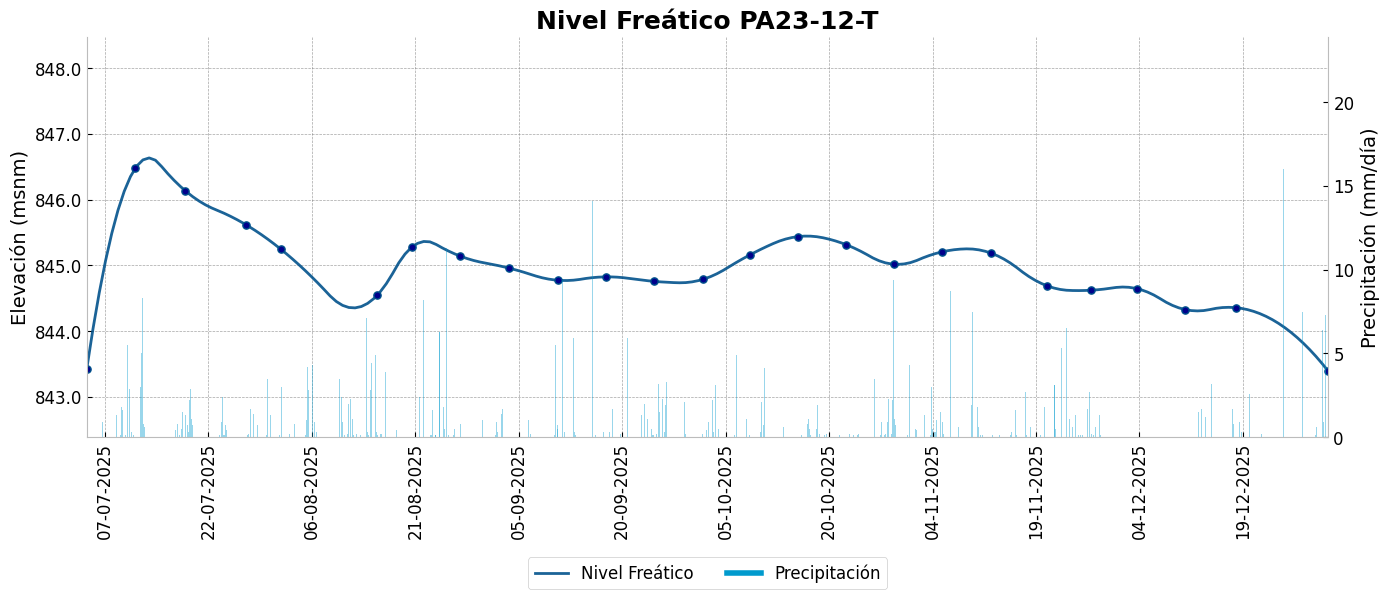

Gráfica insertada en PA23-12-T en la celda C20


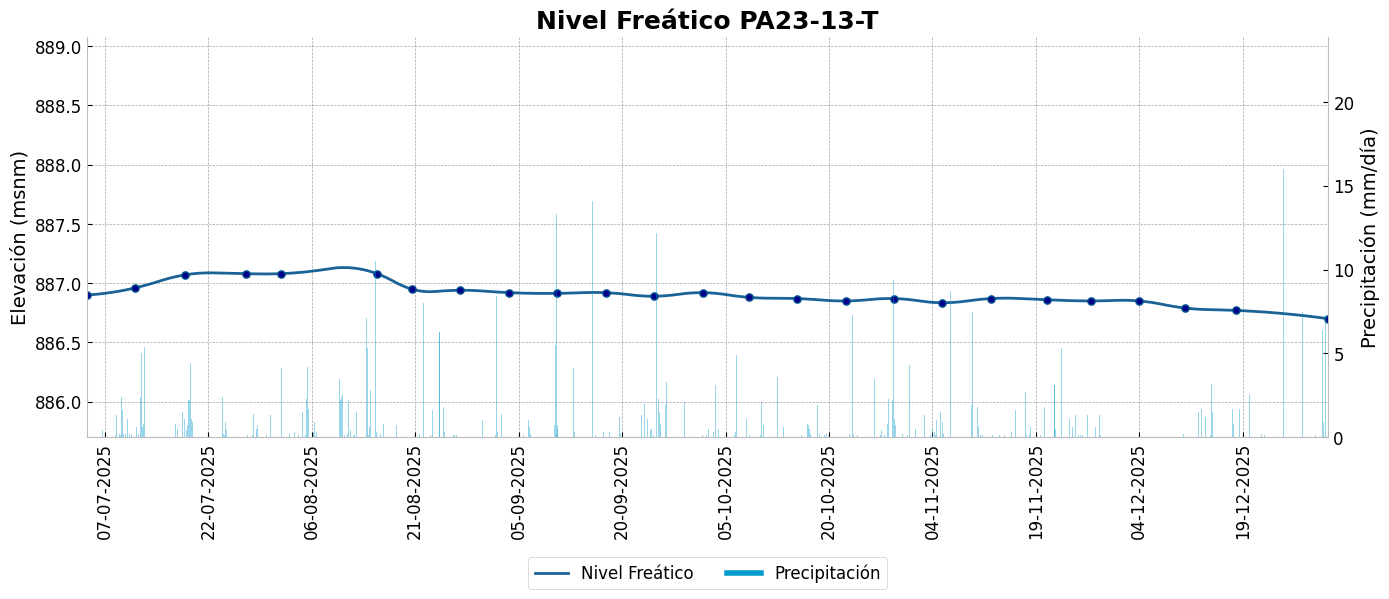

Gráfica insertada en PA23-13-T en la celda C20


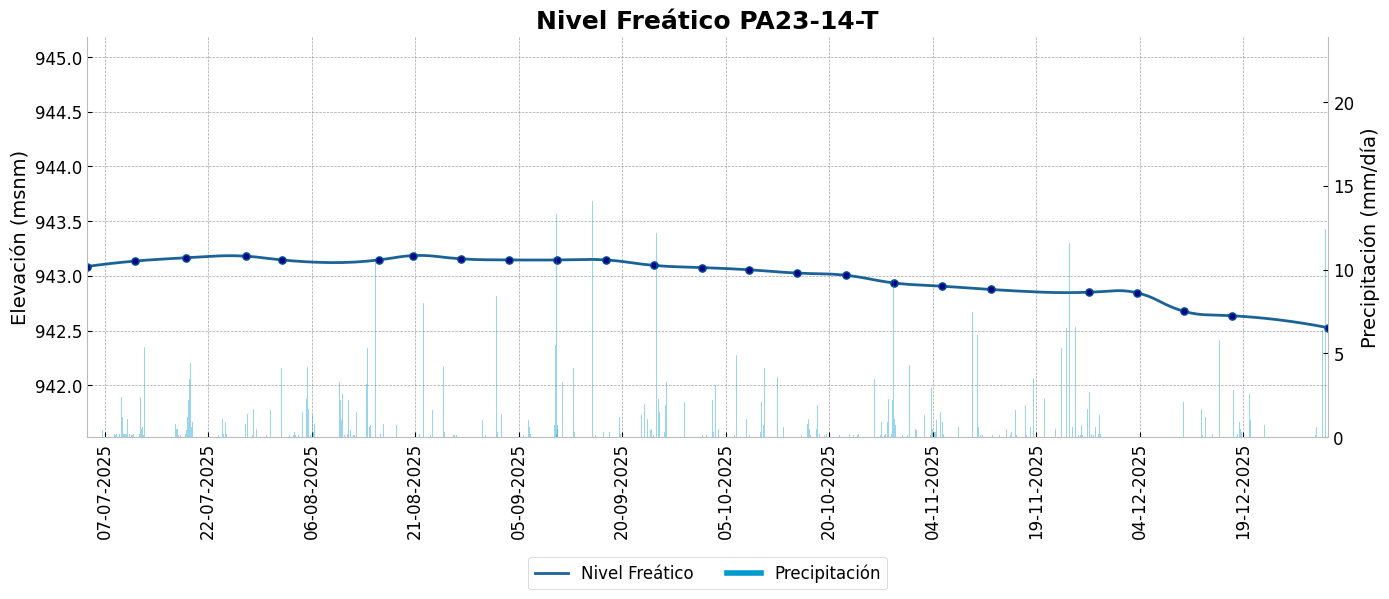

Gráfica insertada en PA23-14-T en la celda C20


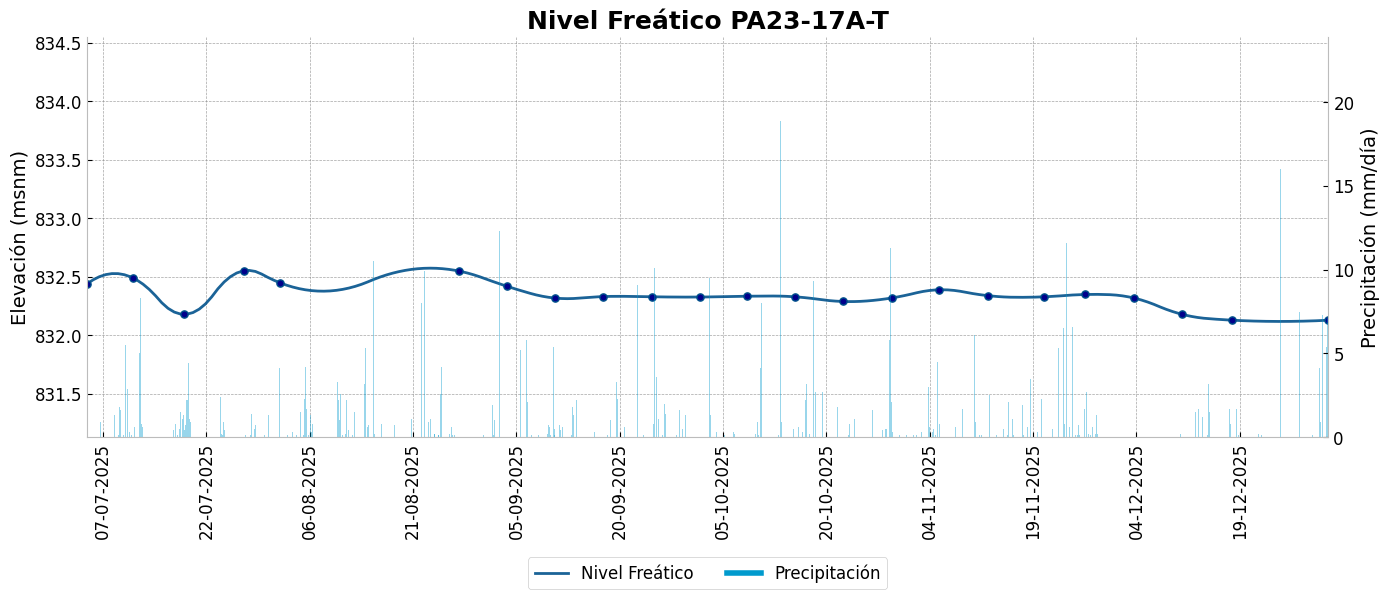

Gráfica insertada en PA23-17A-T en la celda C20


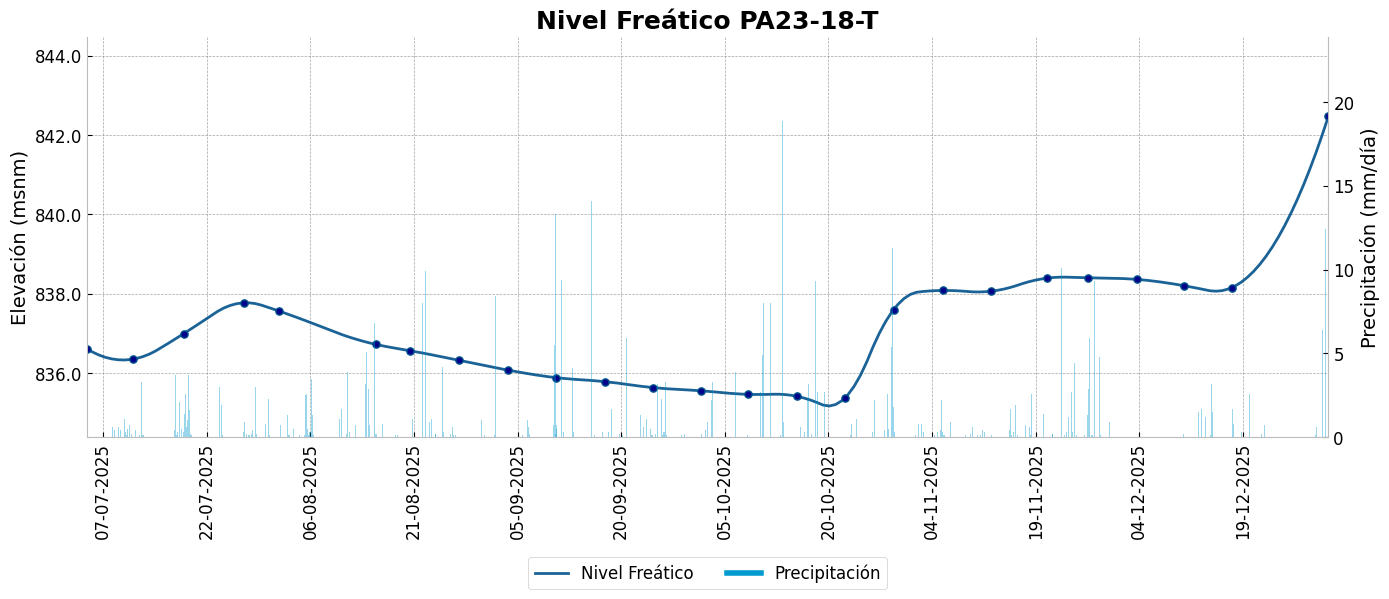

Gráfica insertada en PA23-18-T en la celda C20


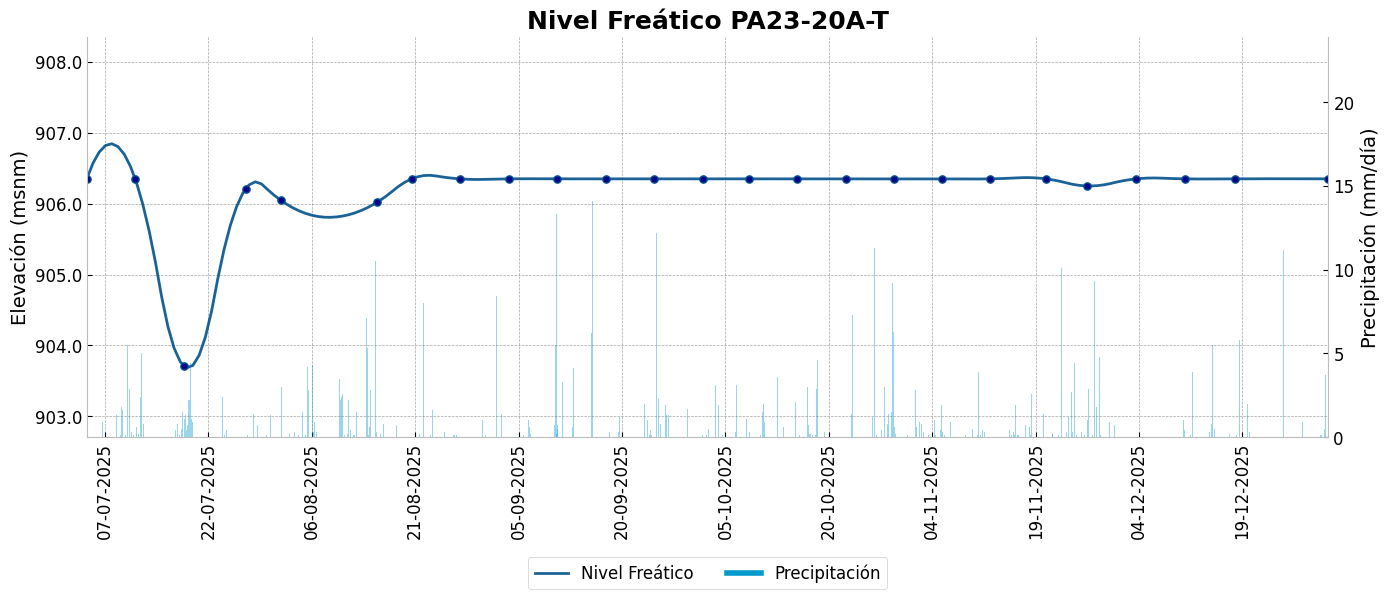

Gráfica insertada en PA23-20A-T en la celda C20


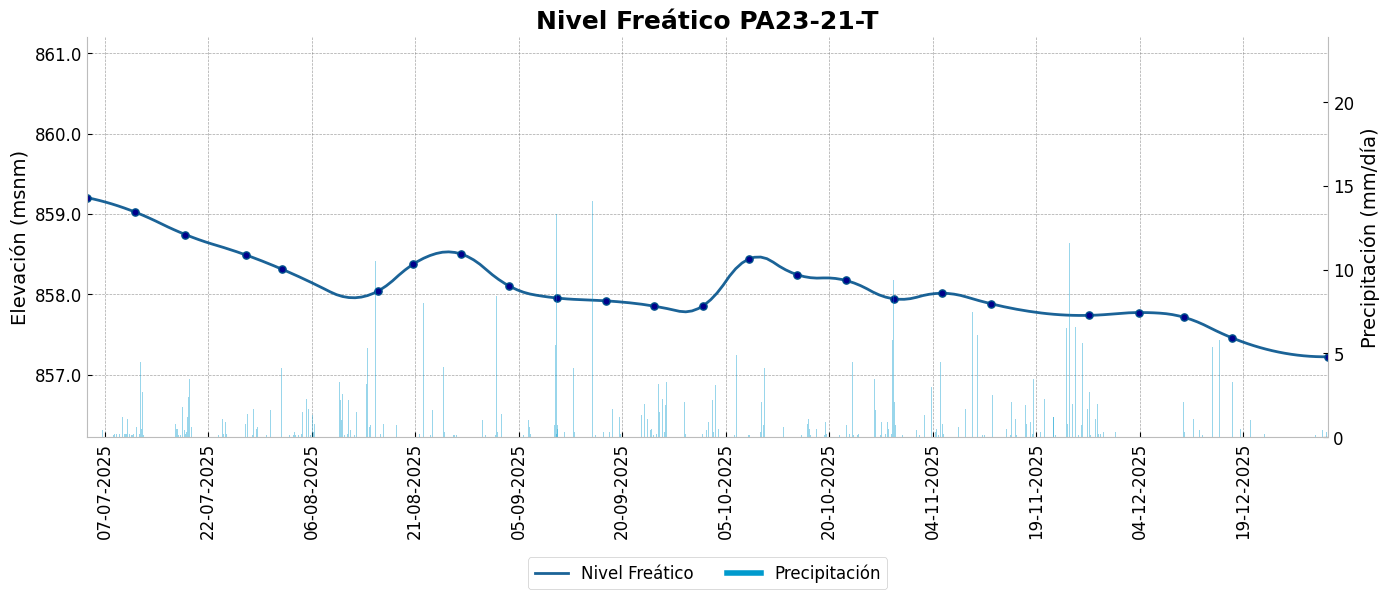

Gráfica insertada en PA23-21-T en la celda C20


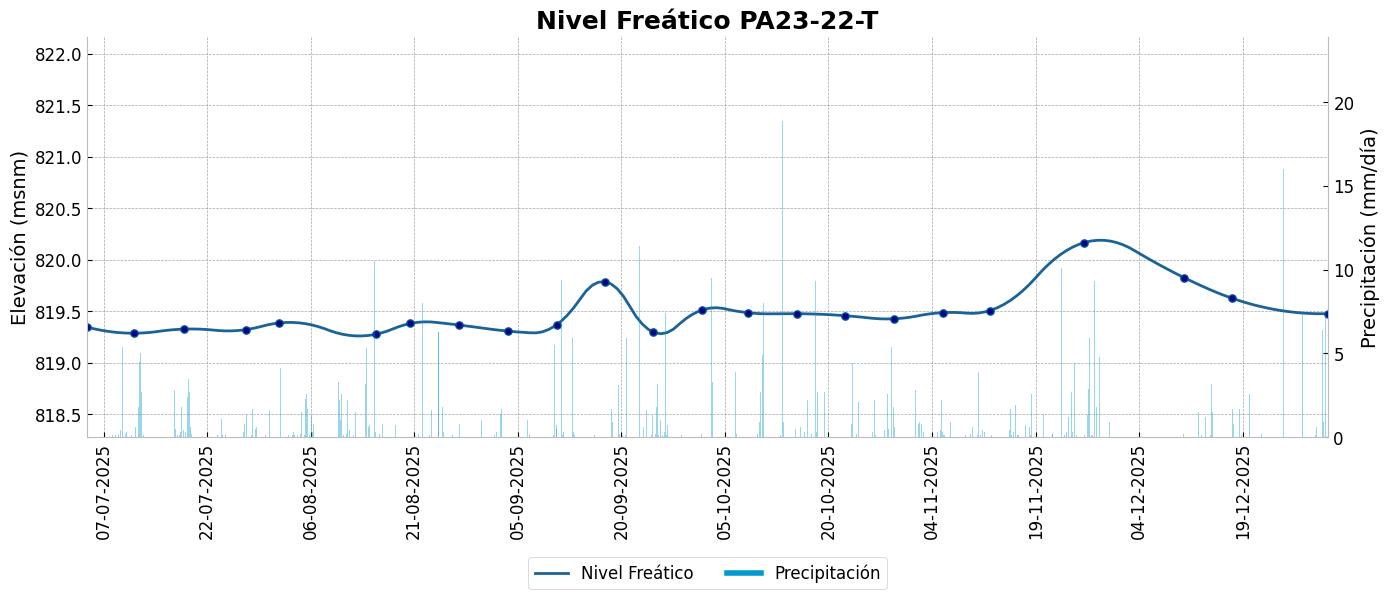

Gráfica insertada en PA23-22-T en la celda C20


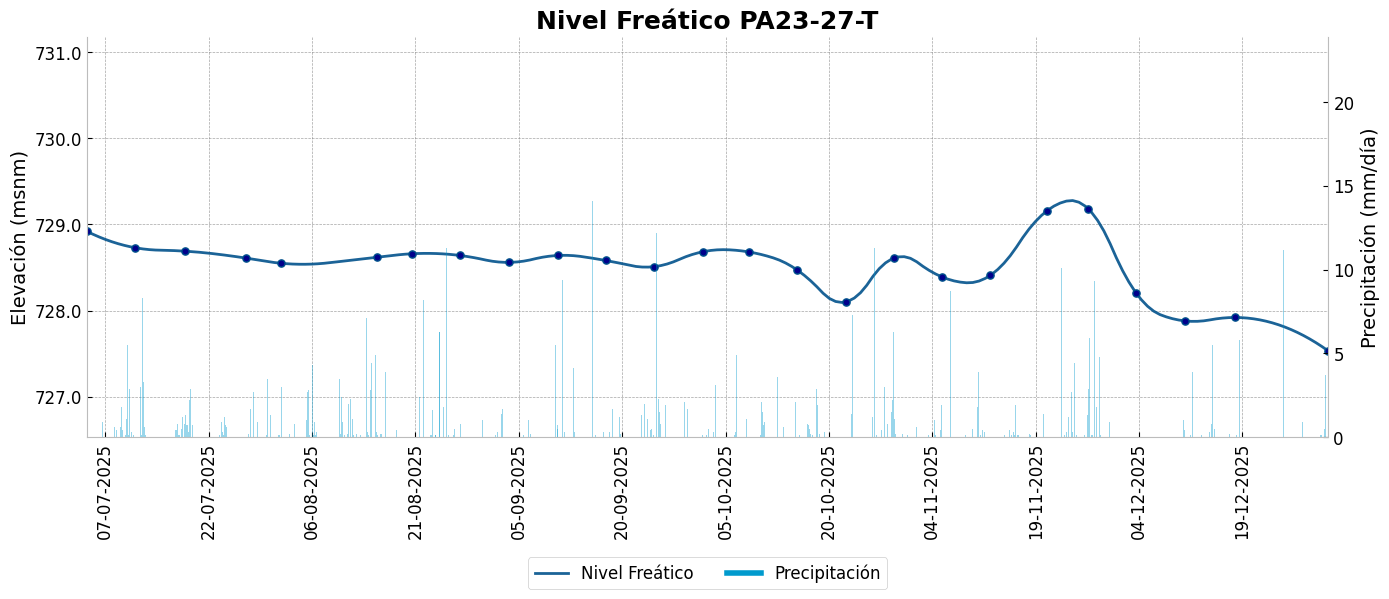

Gráfica insertada en PA23-27-T en la celda C20


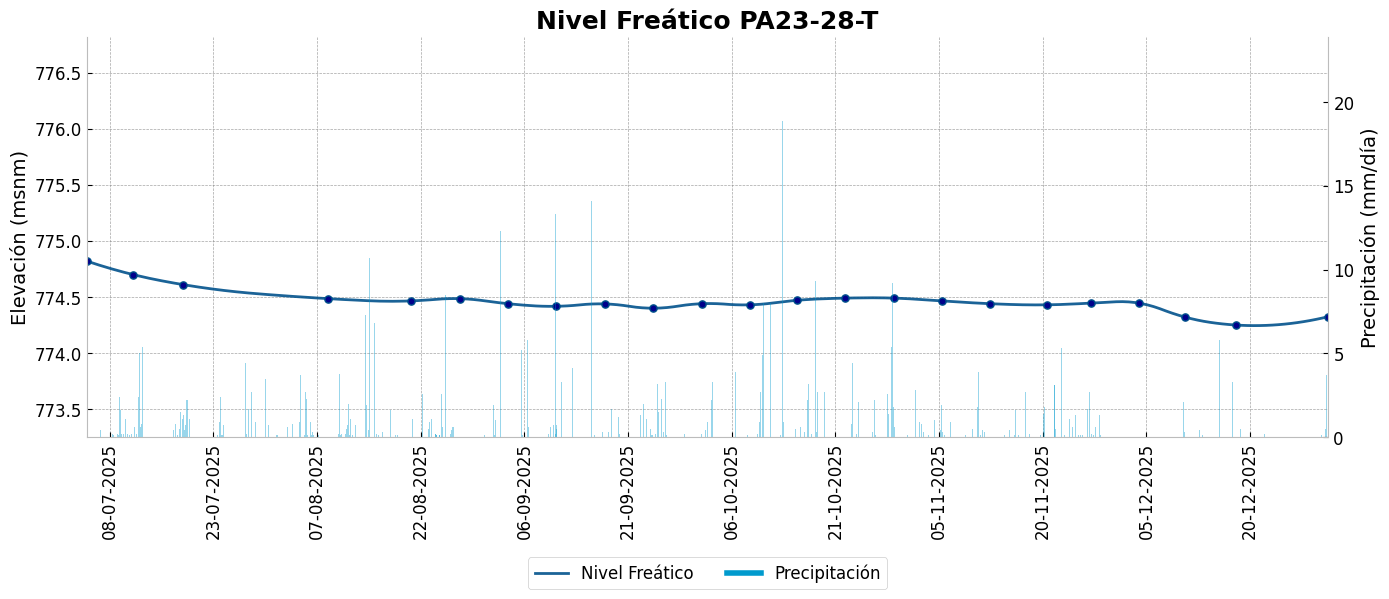

Gráfica insertada en PA23-28-T en la celda C20


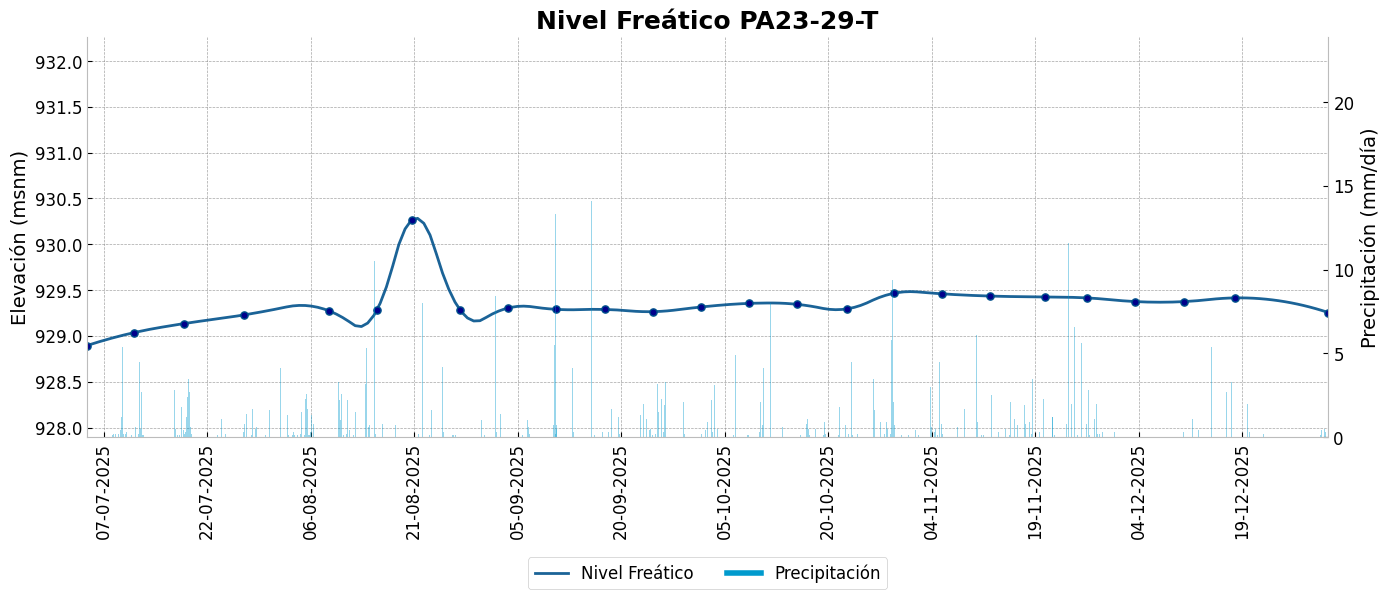

Gráfica insertada en PA23-29-T en la celda C20


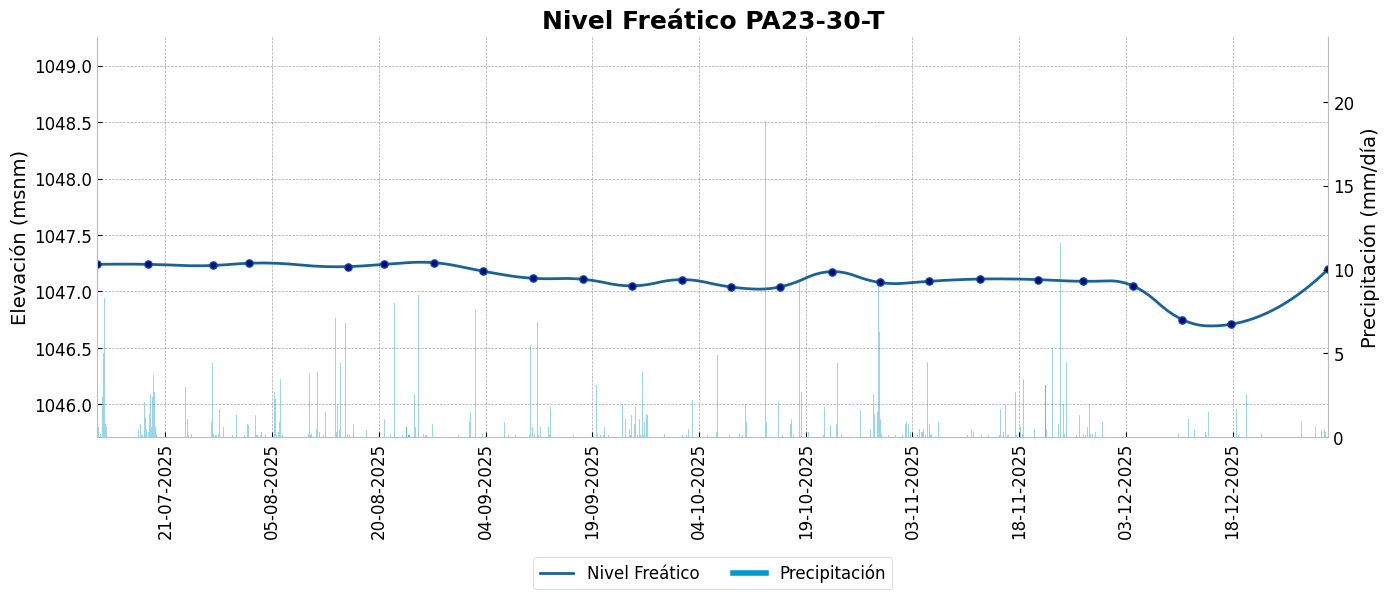

Gráfica insertada en PA23-30-T en la celda C20


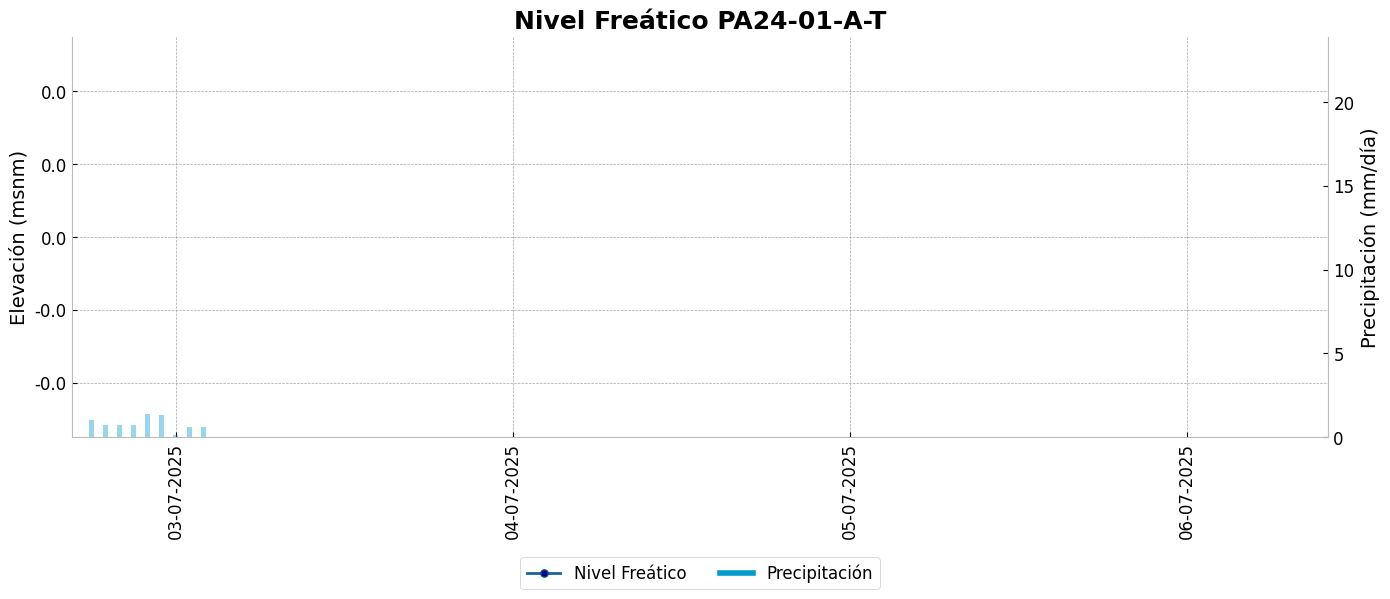

Gráfica insertada en PA24-01-A-T en la celda C20


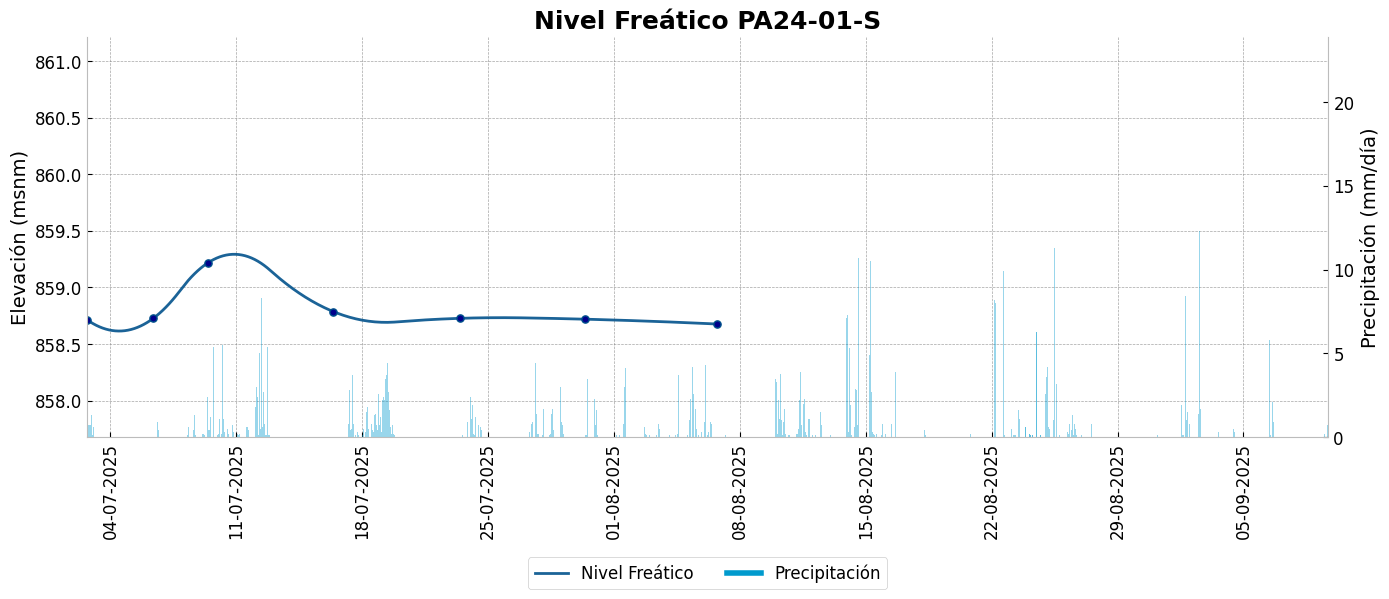

Gráfica insertada en PA24-01-S en la celda C20


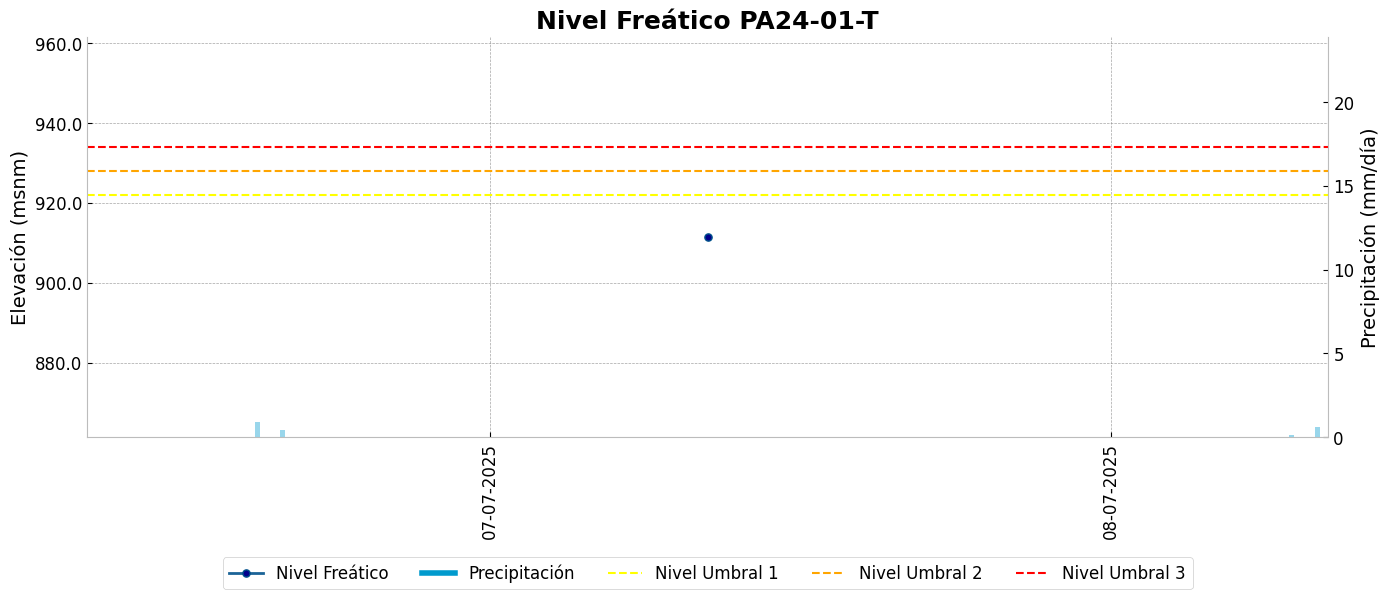

Gráfica insertada en PA24-01-T en la celda C20


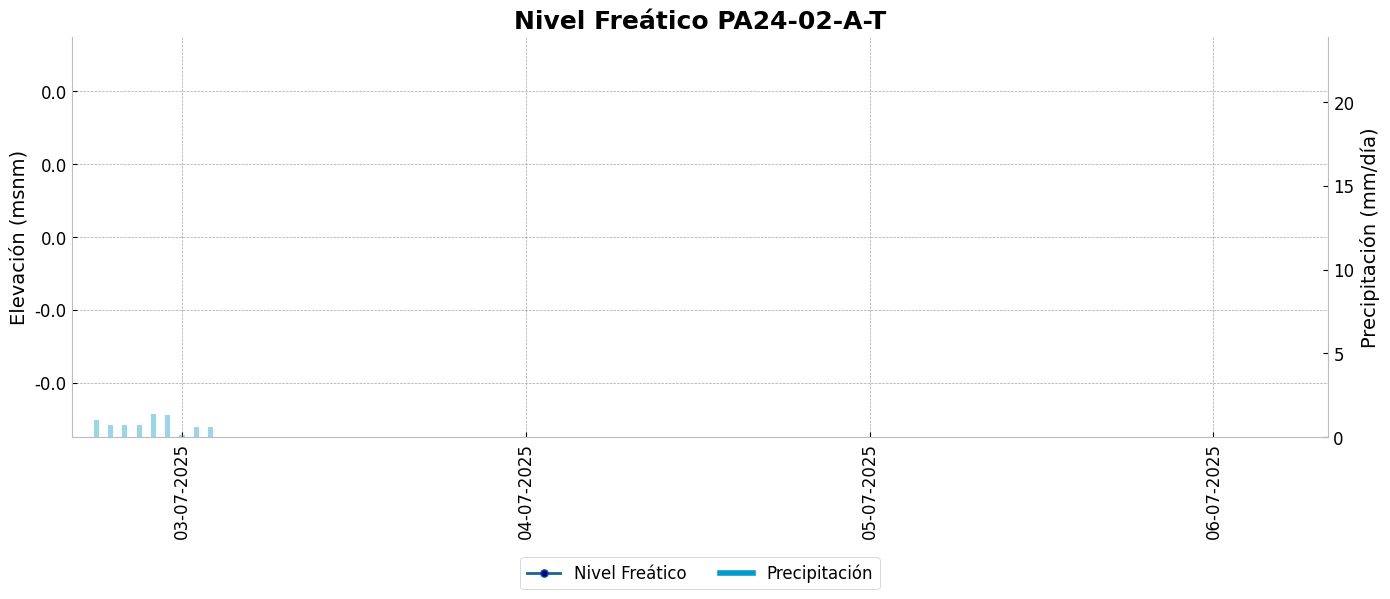

Gráfica insertada en PA24-02-A-T en la celda C20


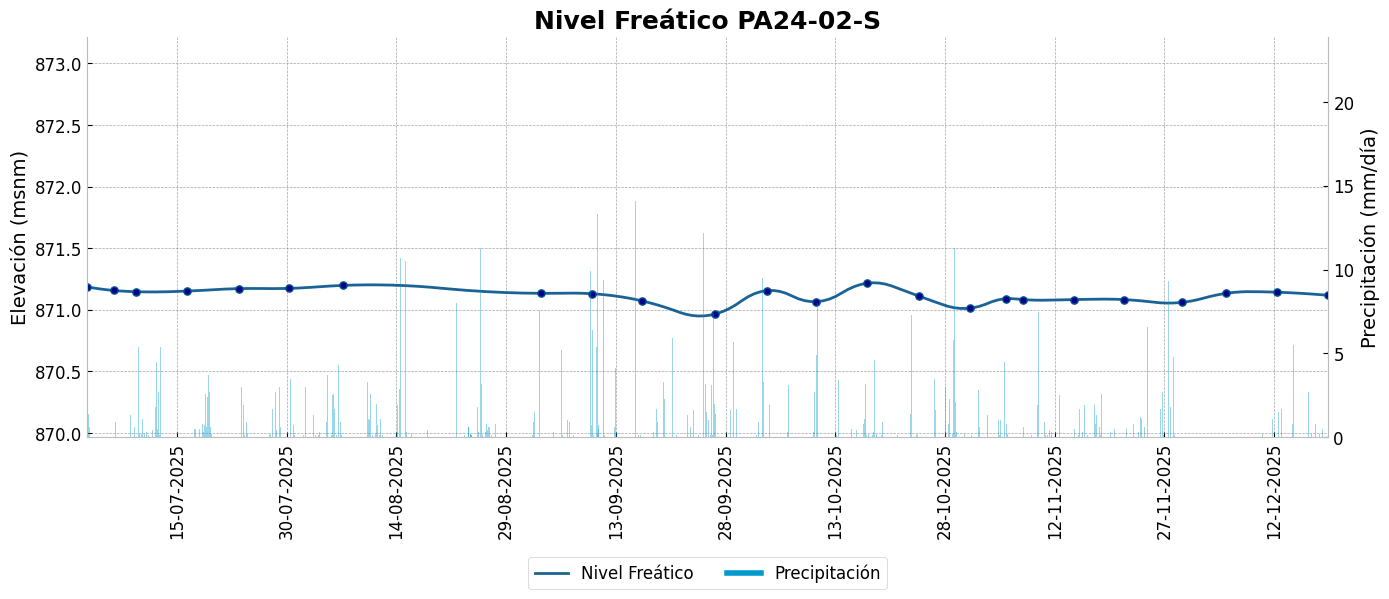

Gráfica insertada en PA24-02-S en la celda C20


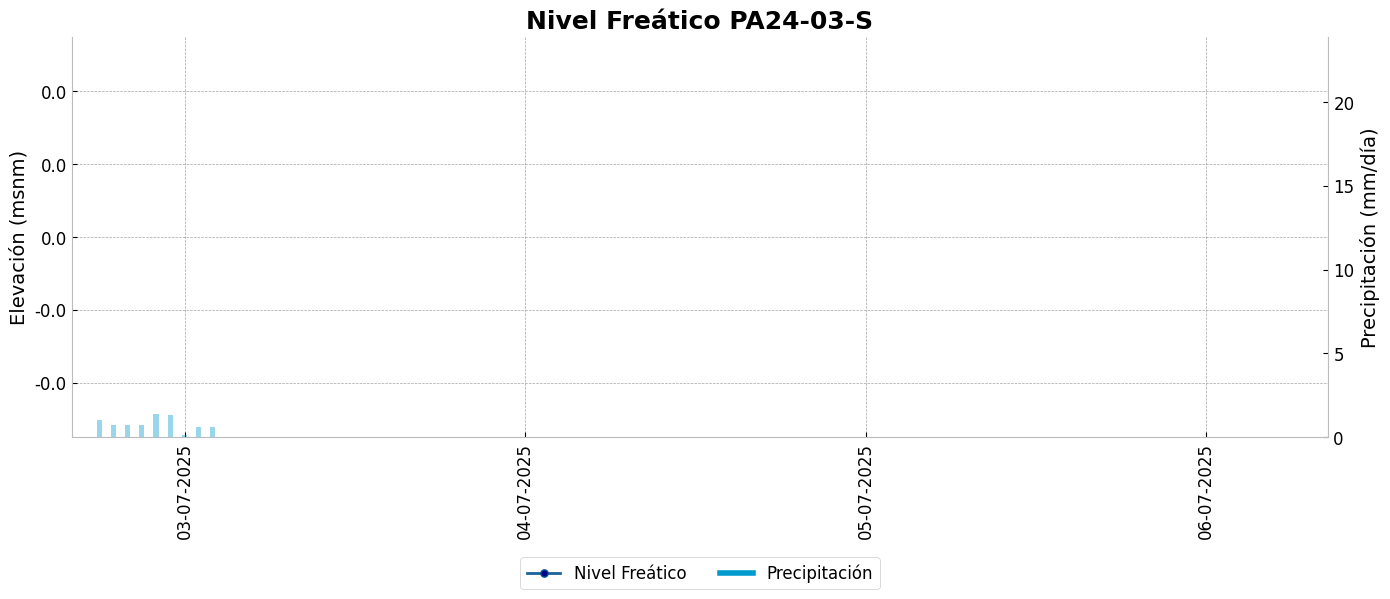

Gráfica insertada en PA24-03-S en la celda C20


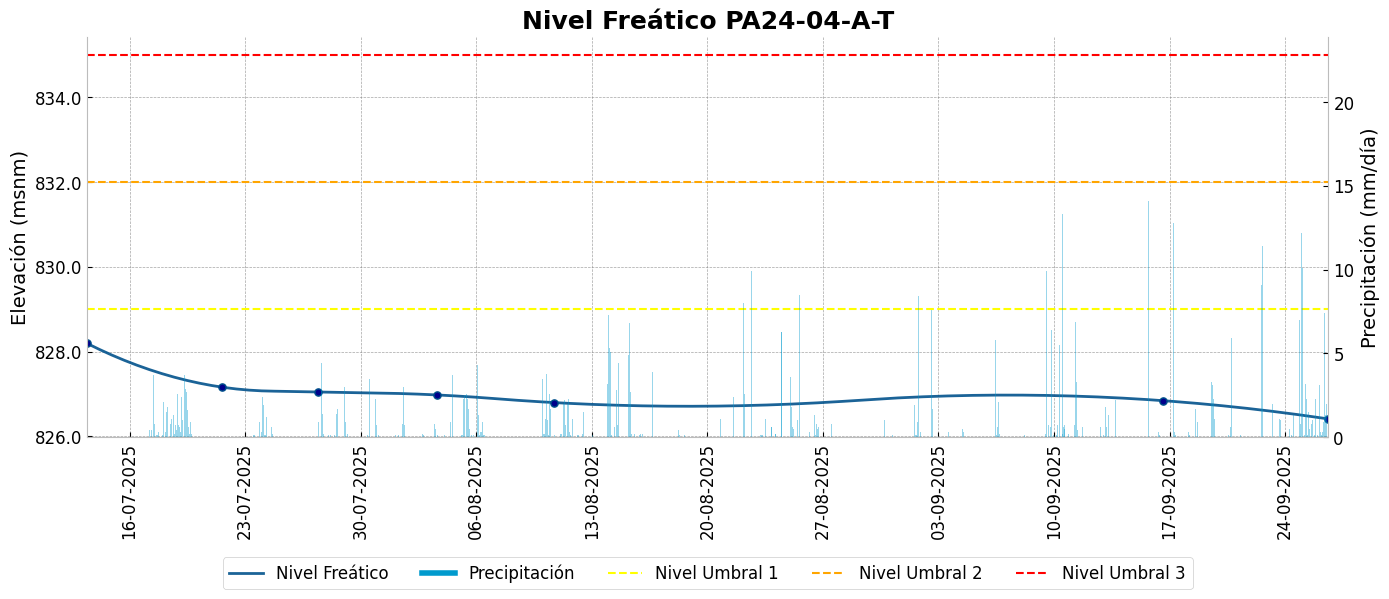

Error al guardar o insertar la gráfica: 'Worksheet PA24-04A-T does not exist.'


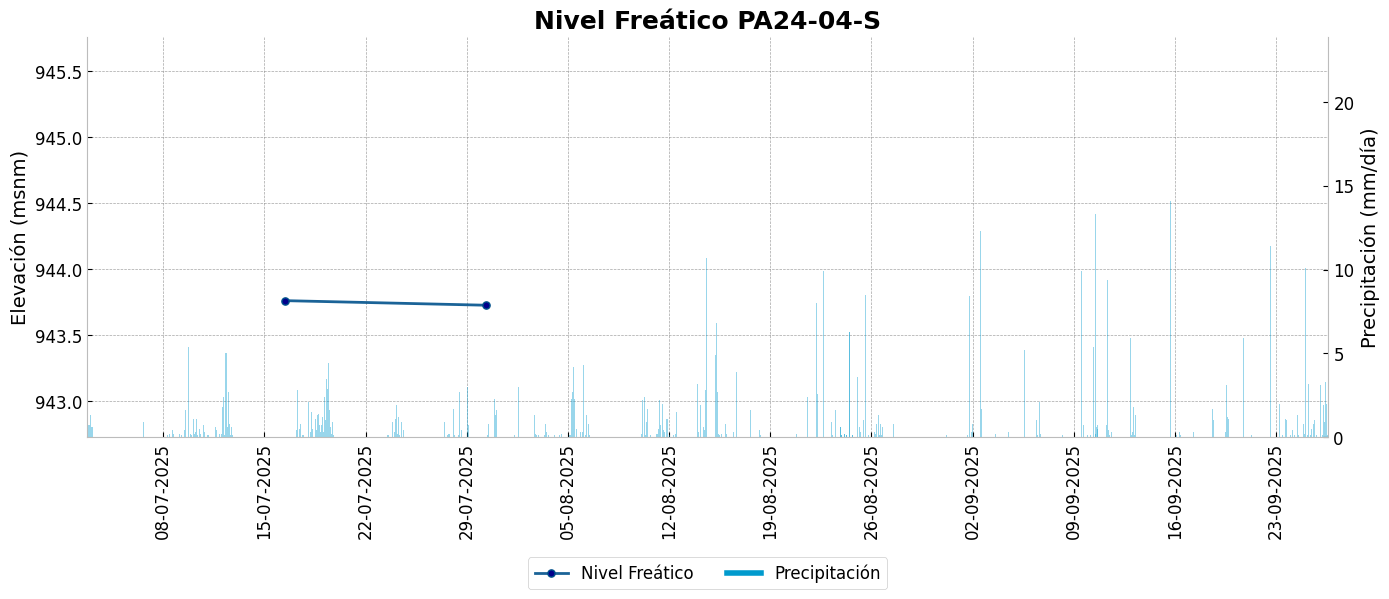

Gráfica insertada en PA24-04-S en la celda C20


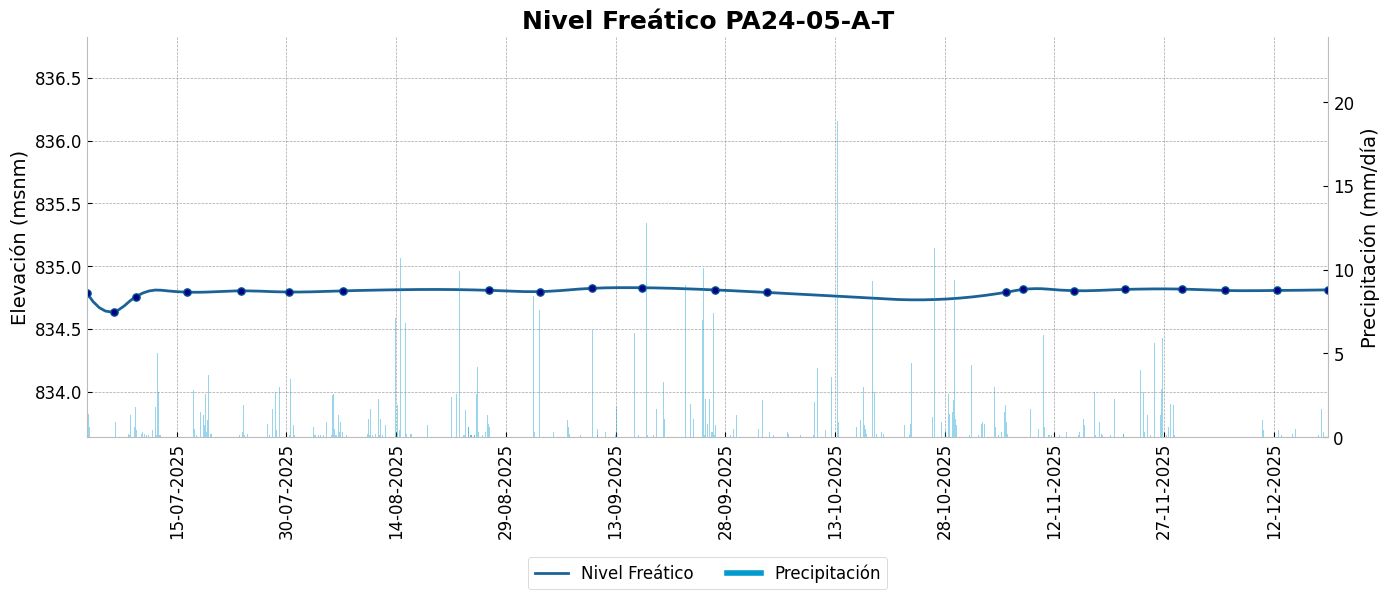

Gráfica insertada en PA24-05-A-T en la celda C20


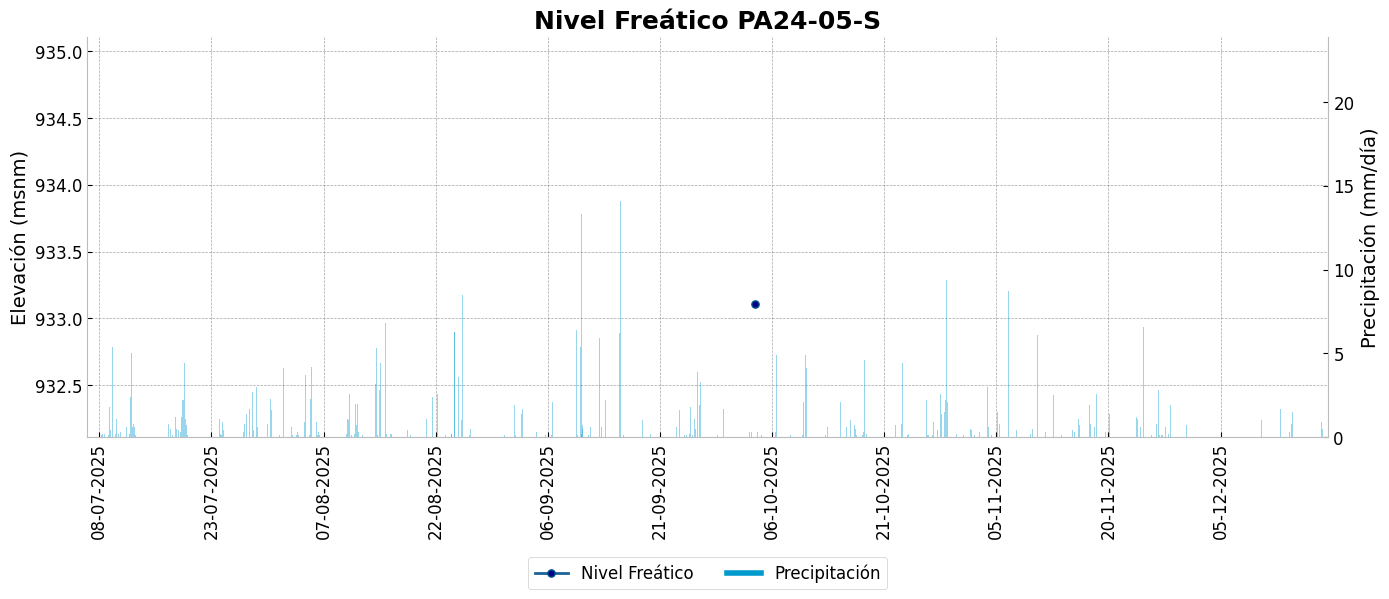

Gráfica insertada en PA24-05-S en la celda C20


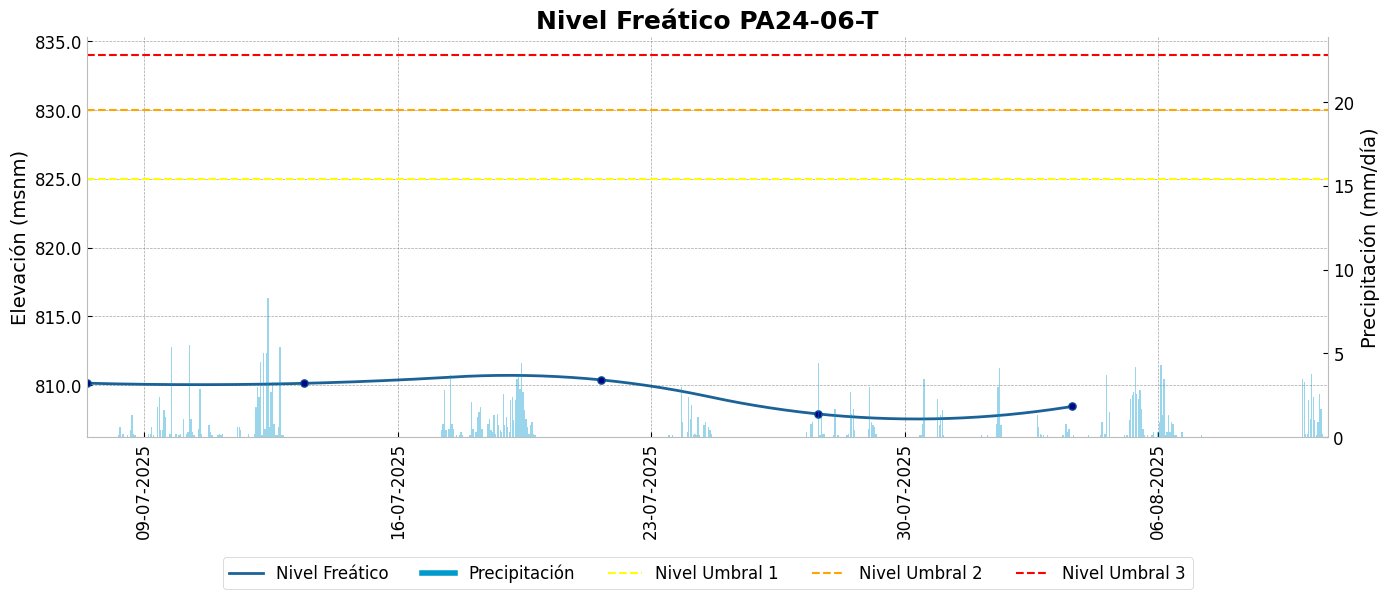

Gráfica insertada en PA24-06-T en la celda C20


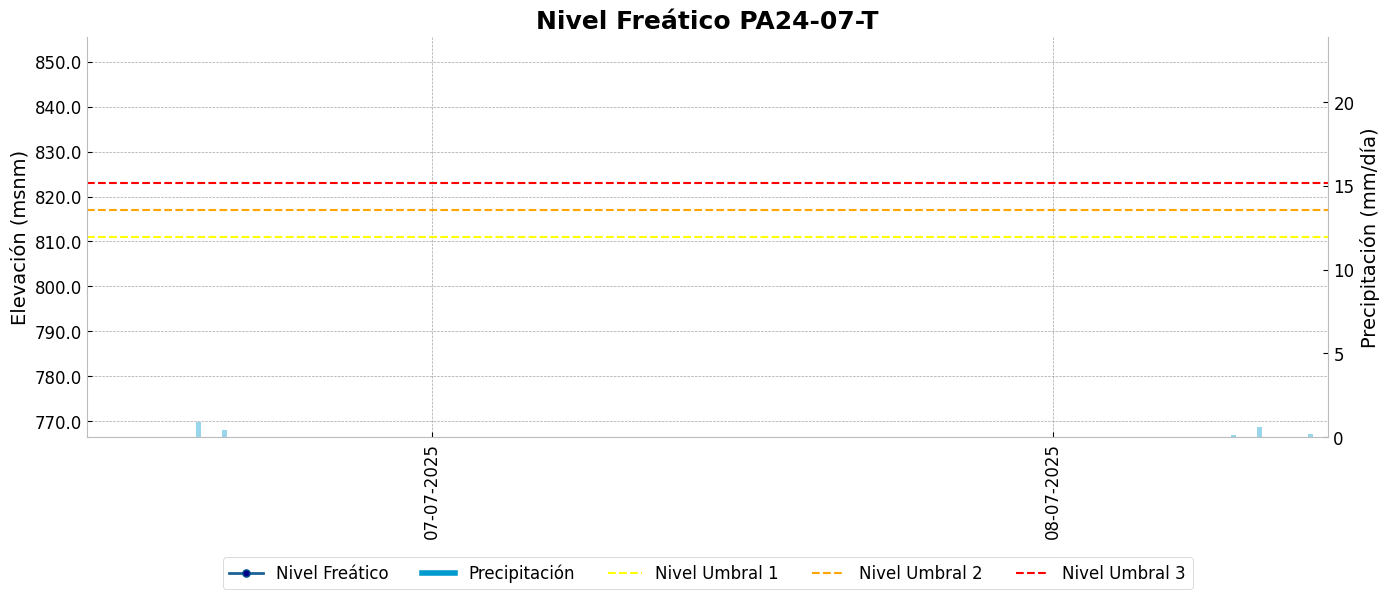

Gráfica insertada en PA24-07-T en la celda C20


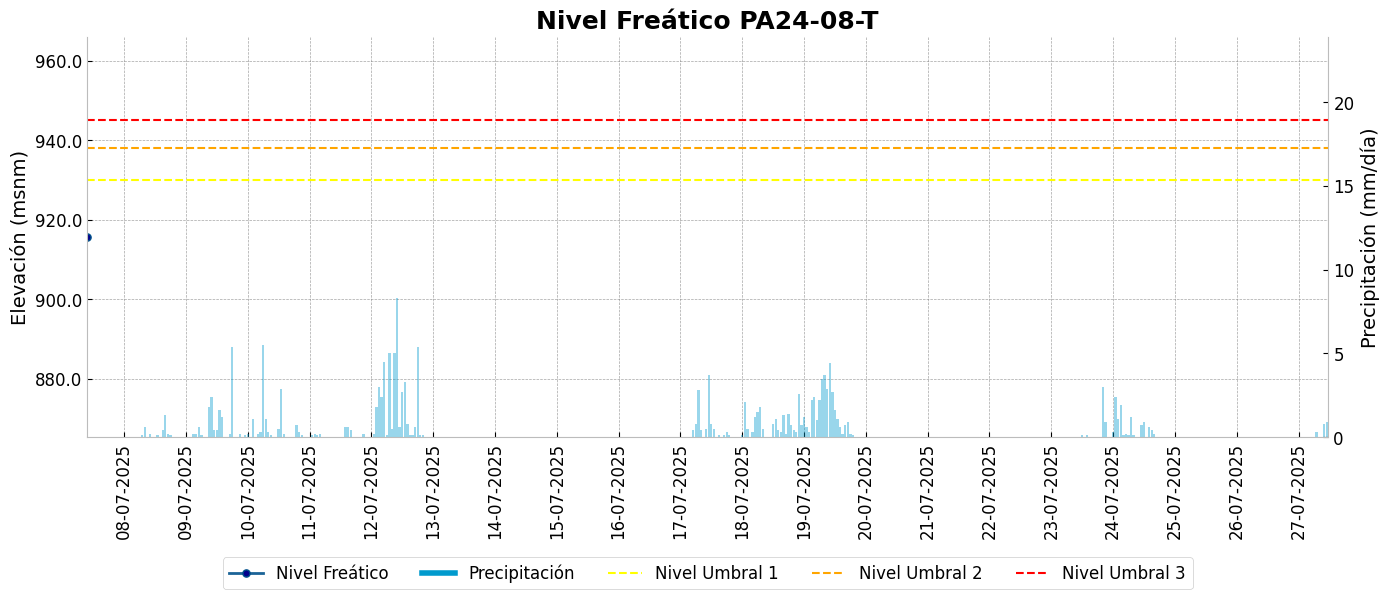

Gráfica insertada en PA24-08-T en la celda C20


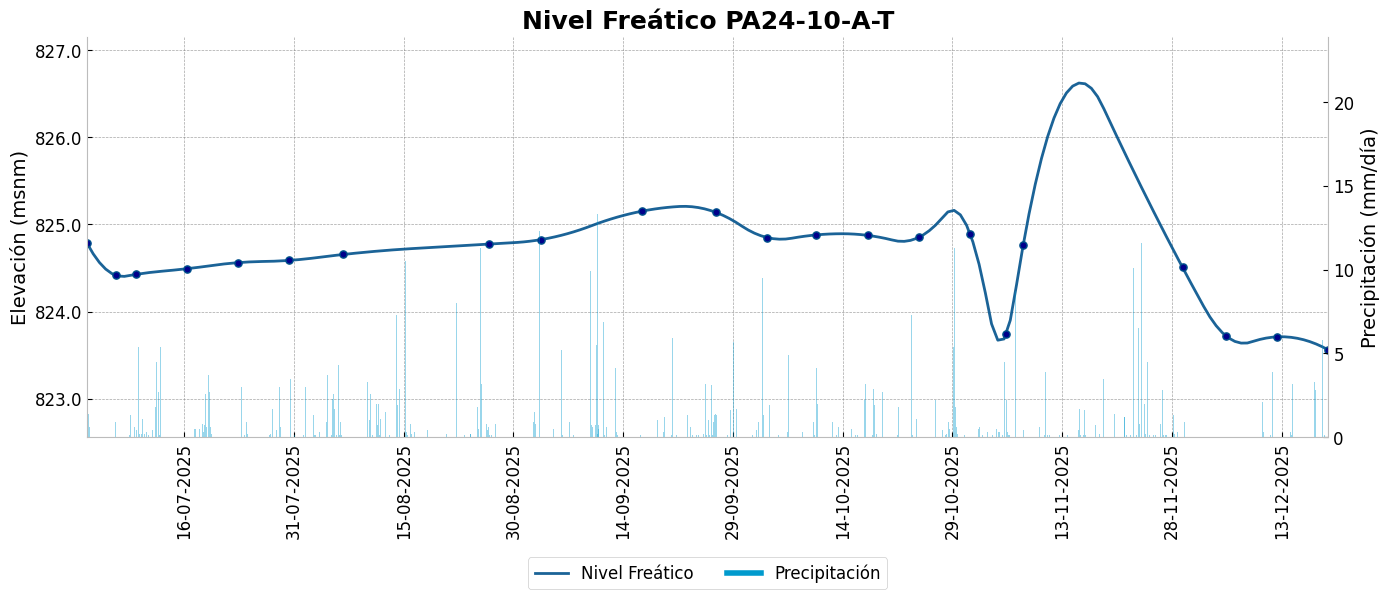

Gráfica insertada en PA24-10-A-T en la celda C20


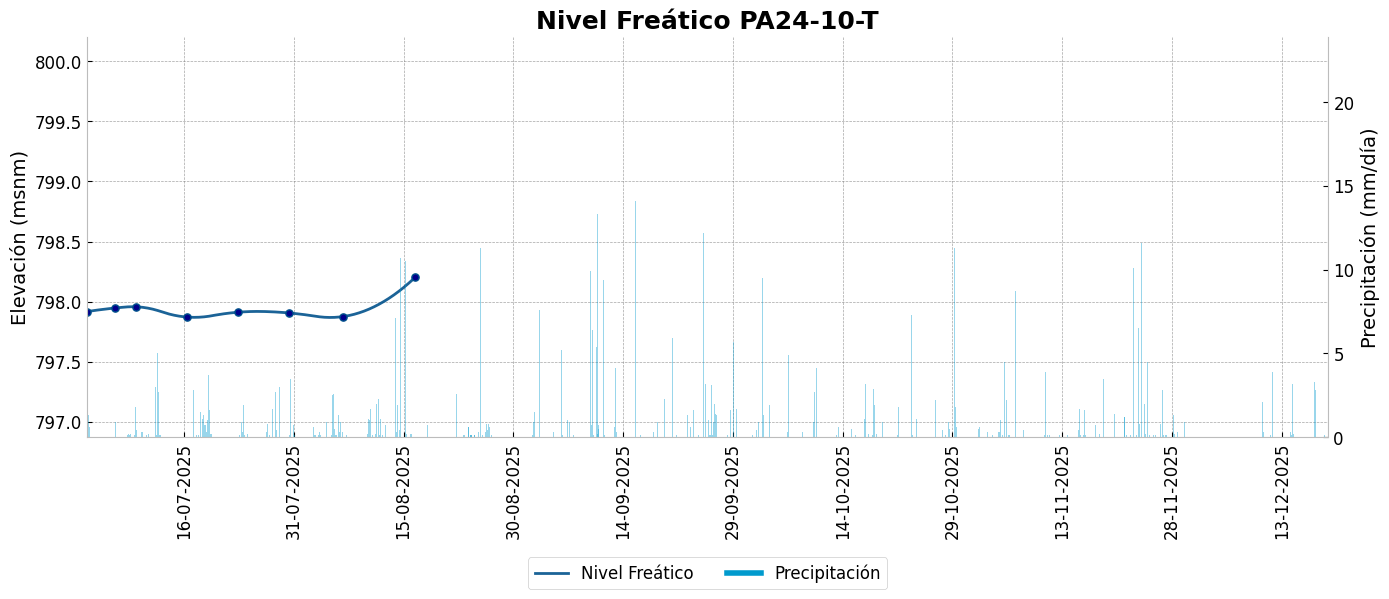

Gráfica insertada en PA24-10-T en la celda C20


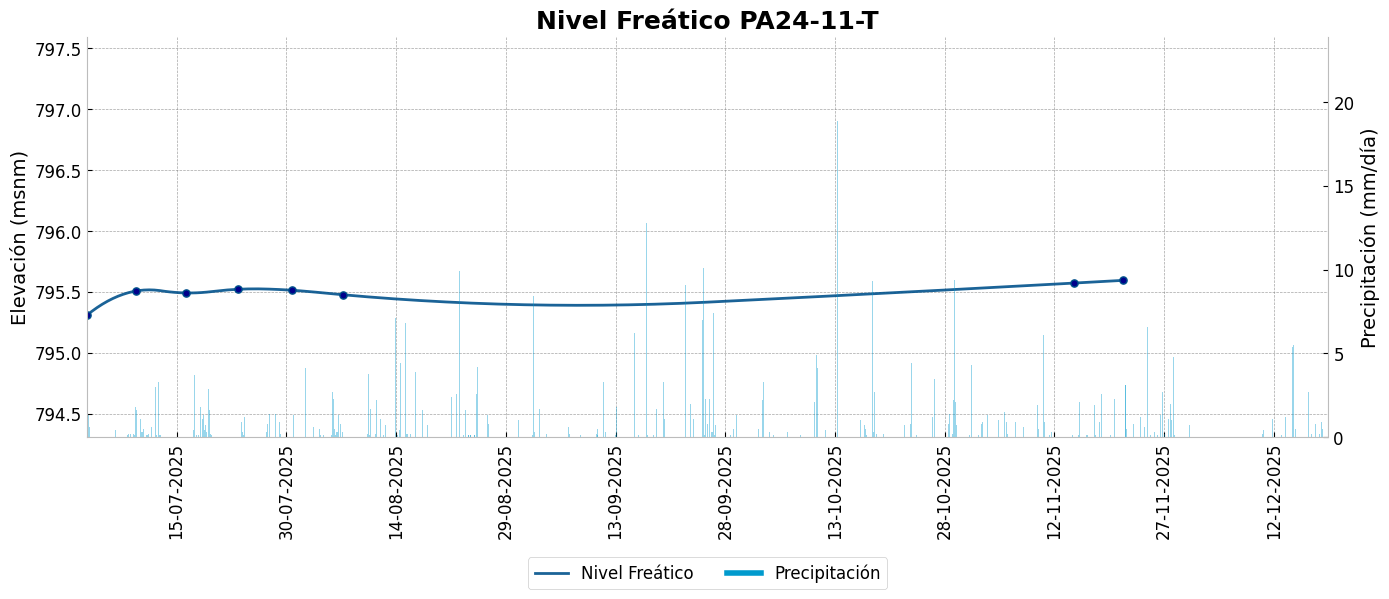

Gráfica insertada en PA24-11-T en la celda C20


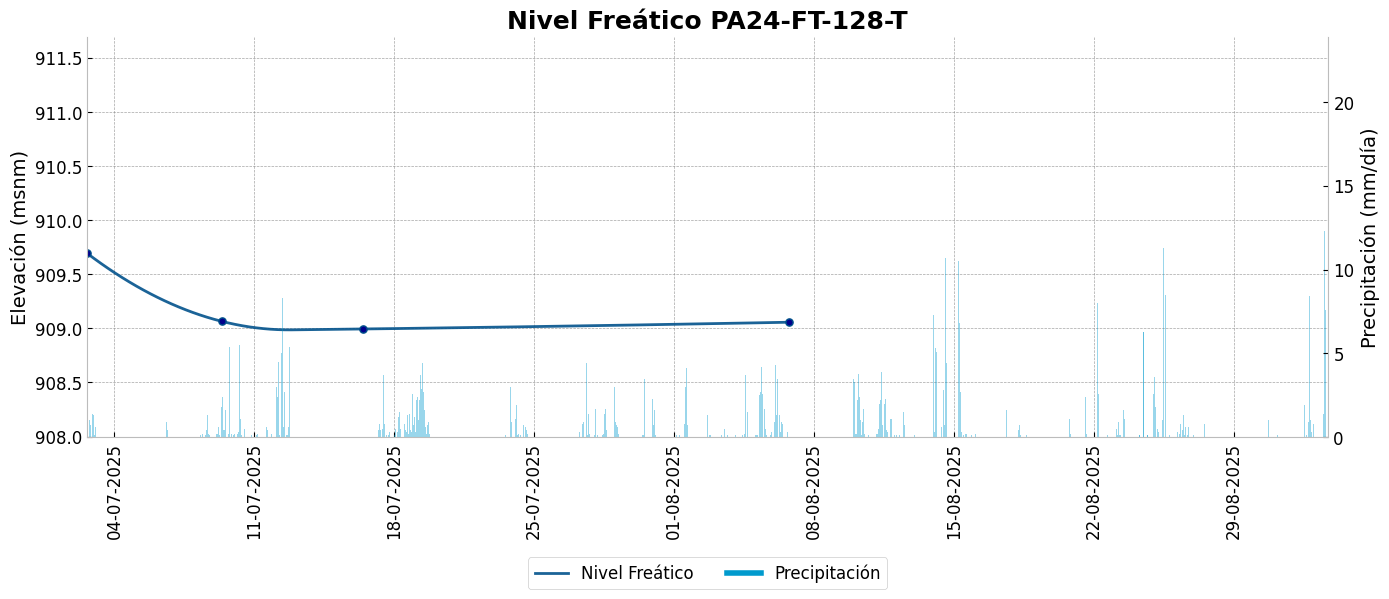

Gráfica insertada en PA24-FT-128-T en la celda C20


: 

In [ ]:
# Asegúrate de ejecutar las celdas anteriores antes de esta celda

# 📅 Parámetros de fecha para filtrar datos de la base de datos
fecha_inicio = '2025-07-01'
fecha_fin = '2025-12-31'


# Diccionario para especificar la hoja y celda donde se insertará cada gráfico
ubicaciones = {

    #=========== SML 2023 ==========#
   
    "PA23-03-T": ("PA23-03-T", "C20"),   # Nombre de tabla: (Nombre de hoja, Celda)
    "PA23-08-T": ("PA23-08-T", "C20"),
    "PA23-11-T": ("PA23-11-T", "C20"),
    "PA23-12-T": ("PA23-12-T", "C20"),
    "PA23-13-T": ("PA23-13-T", "C20"),
    "PA23-14-T": ("PA23-14-T", "C20"),
    "PA23-17A-T": ("PA23-17A-T", "C20"),
    "PA23-18-T": ("PA23-18-T", "C20"),
    "PA23-20A-T": ("PA23-20A-T", "C20"),
    "PA23-21-T": ("PA23-21-T", "C20"),
    "PA23-22-T": ("PA23-22-T", "C20"),
    "PA23-27-T": ("PA23-27-T", "C20"),
    "PA23-28-T": ("PA23-28-T", "C20"),
    "PA23-29-T": ("PA23-29-T", "C20"),
    "PA23-30-T": ("PA23-30-T", "C20"),

    #=== SML 2024 COMPLEMENTARIOS ====#
    "PA24-01-A-T": ("PA24-01-A-T", "C20"),
    "PA24-01-S": ("PA24-01-S", "C20"),
    "PA24-02-A-T": ("PA24-02-A-T", "C20"),
    "PA24-02-S": ("PA24-02-S", "C20"),
    "PA24-03-A-T": ("PA24-03-A-T", "C20"),
    "PA24-03-S": ("PA24-03-S", "C20"),
    "PA24-04-S": ("PA24-04-S", "C20"),
    "PA24-05-S": ("PA24-05-S", "C20"),
    "PA24-05-A-T": ("PA24-05-A-T", "C20"),
    "PA24-10-A-T": ("PA24-10-A-T", "C20"),
    "PA24-10-T": ("PA24-10-T", "C20"),
    "PA24-11-T": ("PA24-11-T", "C20"),
    "PA24-28-T": ("PA24-28-T", "C20"),
    "PA24-FT-128-T": ("PA24-FT-128-T", "C20"),

    #=== SML 2024 PERFORACIONES ====#
    "PA24-01-T": ("PA24-01-T", "C20"),
    "PA24-02-T": ("PA24-02-T", "C20"),
    "PA24-03-T": ("PA24-03-T", "C20"),
    "PA24-04-A-T": ("PA24-04A-T", "C20"),
    "PA24-05-T": ("PA24-05-T", "C20"),
    "PA24-06-T": ("PA24-06-T", "C20"),
    "PA24-07-T": ("PA24-07-T", "C20"),
    "PA24-08-T": ("PA24-08-T", "C20"),
    "PA24-09-T": ("PA24-09-T", "C20"),
    "PA24-12-T": ("PA24-12-T", "C20"),

    # Añade más ubicaciones según sea necesario
}

# Ruta del archivo Excel donde se insertarán los gráficos
excel_path = r"Reporte\2500-DRT-MGP-000-V0.xlsx"

# Conexión a la base de datos y generación de gráficos
conexion = connect_to_db('192.168.60.175', # Host
                         'alexism',  # Usuario
                         'Data.GDR$2024',  # Contraseña
                         'gdr_database',  # Base de datos
                         '5432')      # Puerto

if conexion: 
        query = f'''SELECT "id_instrumento", "fecha", "hora", "elevacion_piezometrica"
                    FROM "MV_PIEZOMETROS".pz_abiertos
                    WHERE "fecha" BETWEEN '{fecha_inicio}' AND '{fecha_fin}' '''
        result, columns = execute_query(conexion, query)
        df = process_data(result, columns)

        if not df.empty: # Si el DataFrame no está vacío

            # Obtener los instrumentos únicos
            instrumentos_unicos = df['id_instrumento'].unique() # Obtener los instrumentos únicos
            
            # Filtrar los instrumentos a omitir para no graficarlos
            instrumentos_baja = {"PA24-03-A-T","PA24-28-T", "PA24-02-T", "PA24-03-T", "PA24-05-T", "PA24-09-T"
                                            }

            # Filtrar los instrumentos y ordenarlos alfabéticamente       
            tablas = sorted([inst for inst in instrumentos_unicos # Filtrar los instrumentos
                      if inst not in instrumentos_baja]) # Filtrar los instrumentos a omitir
            
            for tabla in tablas:
                # Filtrar los datos por instrumento
                df_instrumento = df[df['id_instrumento'] == tabla].copy() # Filtrar los datos por instrumento
                # Convertir la columna 'Fecha_Hora' a formato datetime
                df_instrumento['Fecha_Hora'] = pd.to_datetime(df_instrumento['Fecha_Hora'])

                if df_instrumento.empty:  # Verificar si el DataFrame está vacío
                    print(f"El instrumento {tabla} no tiene datos para graficar.")
                    continue
                query_precip = f'''SELECT "fecha", "hora", "rain_mm_tot" FROM "MV_NAD_DR"."00_em_via12" 
                                WHERE "fecha" BETWEEN '{fecha_inicio}' AND '{fecha_fin}' '''
                result_precip, columns_precip = execute_query(conexion, query_precip)
                df_precip = process_precipitation_data(result_precip, columns_precip)

                if df_precip.empty or 'Fecha_Hora' not in df_precip.columns:
                    print(f"⚠️ No hay datos de precipitación para {tabla} en el rango {fecha_inicio} a {fecha_fin}")
                    print(f"   Se omitirá la gráfica de precipitación para este instrumento.")
                    # Puedes crear un DataFrame vacío con la estructura correcta
                    df_precip = pd.DataFrame(columns=['Fecha_Hora', 'rain_mm_tot'])
                
                # Manejar el error de ubicación sin detener el ciclo
                try:
                    sheet_name, cell = ubicaciones[tabla]
                except KeyError:
                    print(f"No se encontró una ubicación para el instrumento {tabla}")
                    continue
                plot_data(df_instrumento, df_precip, tabla, conexion, excel_path, sheet_name, cell)

close_connection(conexion) # Cerrar la conexión a la base de datos